# Preparation 

In [2]:
import os
import glob
import time
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.nn.parameter as P
import torchvision
from torchvision import transforms, datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_data = datasets.ImageFolder(os.path.normpath('/home/md359230/DeepLearning/assignment1/data/fruits-360/Training'),
                                  transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4)

In [6]:
test_data = datasets.ImageFolder(os.path.normpath('/home/md359230/DeepLearning/assignment1/data/fruits-360/Test'),
                                  transform=transform)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 100, 100])


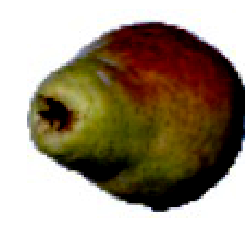

In [7]:
def fruitImShow(img):
    npimg = img.numpy()
    img = plt.imshow(npimg)
    plt.axis('off')
    plt.show()

for i, images in enumerate(train_loader):
    if i >= 0:
        print(images[0].squeeze().size())
        fruitImShow(np.transpose(images[0][0,:,:,:], [1, 2, 0]))
        break

In [8]:
example, no = next(iter(train_loader))

In [9]:
example.size()

torch.Size([128, 3, 100, 100])

In [10]:
tmp = example
print(tmp.size())
tmp = nn.Conv2d(3, 8, 5)(tmp)
print(tmp.size())
tmp = nn.MaxPool2d((2,2))(tmp)
print(tmp.size())
tmp = nn.Conv2d(8, 16, 11)(tmp)
print(tmp.size())
print(tmp.view(4,-1, 16 * 38 * 38).size())
tmp = nn.MaxPool2d(2,2)(tmp)
print(tmp.size())

torch.Size([128, 3, 100, 100])
torch.Size([128, 8, 96, 96])
torch.Size([128, 8, 48, 48])
torch.Size([128, 16, 38, 38])
torch.Size([4, 32, 23104])
torch.Size([128, 16, 19, 19])


In [11]:
! ls -R /home/md359230/DeepLearning/assignment1/data/fruits-360/Training/ | wc -l

49191


In [12]:
! ls -R /home/md359230/DeepLearning/assignment1/data/fruits-360/Test/ | wc -l

16707


# Define Neural Network

## Building blocks of the architecture 

In [375]:
class MyBatchNormalization2d(nn.Module):
    """Class containing custom implementation of batch normalization.
    """
    def __init__(self, epsilon=1e-5):
        """Derived constructor.
        
        :param epsilon: Number to add to standard deviation to aviod zeros.
        :return: MyBatchNormalization2d object."""
        super(MyBatchNormalization2d, self).__init__()
        self.register_buffer('epsilon', torch.Tensor([epsilon]))
        self.shift = P.Parameter(torch.Tensor(1))
        self.scale = P.Parameter(torch.Tensor(1))
        init.zeros_(self.shift)
        init.uniform_(self.scale)
        
    def forward(self, x):
        """Method implementing batch normalization logic.
        
        :param x: Input tensor of shape (N x C x W x H).
        :return: Batch normalized x."""
        # Compute means and stds per channel
        batch_size, channels, width, height = x.size()
        
        x_agg = x.permute((1, 0, 2, 3))\
                 .contiguous()\
                 .view(-1, batch_size * width * height)
        
        stds = torch.std(x_agg, 
                         dim=1, 
                         unbiased=False)
        means = torch.mean(x_agg, 
                           dim=1)
        
        # Scale input to have 0 mean and unit variance (remeber about epsilon!)
        self.tensor_mean = torch.ones(width, height).cuda()
        self.tensor_std = torch.eye(height).cuda()
        self.tensor_means = torch.stack([self.tensor_mean * means[i] for i in range(channels)])
        self.tensor_stds = torch.stack([self.tensor_std * (1 / (stds[i] + self.epsilon)) for i in range(channels)])
        x = torch.matmul((x - self.tensor_means), self.tensor_stds)
        
        # Scale input using parameters
        tensor_shift = torch.stack([self.tensor_mean * self.shift for i in range(channels)])
        tensor_scale = torch.stack([self.tensor_std * self.scale for i in range(channels)])
        x = torch.matmul(x, tensor_scale) + tensor_shift
        
        # Return the result
        return x

In [ ]:
class MyBatchNormalization1d(nn.Module):
    pass

In [376]:
def convolutional_layer(in_channels, 
                        out_channels,
                        kernel_size,
                        batchnorm_module='default', 
                        *args, 
                        **kwargs): 
    """Function for flexible construction of convolutional layers for the network.
    
    :param in_channels: Number of input channels.
    :param out_channels: Number of channels produced by the output.
    :param kernel_size: Kernel size for convolutional layer.
    :param batchnorm_module: Must be in ('default', 'custom'). Should Pytorch's or own BN 
    normalization be used?
    :param *args: Additional arguments to pass to convolutional layer.
    :param **kwargs: Additional keyword arguments to pass to convolutional layer.
    :return: Layer consisting of convolution, batch normalization and max pooling."""
    batchnorm_modules = nn.ModuleDict([
        ['default', nn.BatchNorm2d(out_channels)],
        ['custom', MyBatchNormalization2d()]
    ])
    
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, *args, **kwargs),
        batchnorm_modules[batchnorm_module],
        nn.MaxPool2d((2,2))
    )

In [377]:
def linear_layer(in_features, 
                 out_feautres, 
                 batchnorm_module='default',
                 activation_function='relu', 
                 *args, 
                 **kwargs):
    """Function for flexible construction of full-connected layers for the network.
    
    :param in_features: Size of input layer.
    :param out_features: Size of output layer.
    :param batchnorm_module: Must be in ('default', 'custom'). Should Pytorch's or own BN 
    normalization be used?
    :param activation_fuction: Must be in ('relu', 'lrelu', 'sigmoid'). Which activation
    function should be used?
    :param *args: Additional arguments to pass to full-connected layer.
    :param **kwargs: Additional keyword arguments to pass to full-connected layer.
    :return: Layer consisting of full-connected module, batch normalization and activation function."""
    batchnorm_modules = nn.ModuleDict([
        ['default', nn.BatchNorm1d(out_feautres)],
        ['custom', nn.BatchNorm1d(out_feautres)]
    ])
    
    activation_functions = nn.ModuleDict([
        ['lrelu', nn.LeakyReLU()],
        ['relu', nn.ReLU()],
        ['sigmoid', nn.Sigmoid()]
    ])

    return nn.Sequential(
        nn.Linear(in_features, out_feautres, *args, **kwargs),
        batchnorm_modules[batchnorm_module],
        activation_functions[activation_function]
    )

In [378]:
class ConvolutionalStack(nn.Module):
    """Class containing implementation of standard convolutional stack.
    """
    def __init__(self, sizes, kernel_sizes, *args, **kwargs):
        """Derived constructor.
        
        :param sizes: iterable with sizes of subsequent convolutional_layers.
        :param kernel_sizes: iterable with sizer of kernels used in subsequent
        convolutional layers.
        :param *args: Additional arguments to pass to convolutional layer.
        :param **kwargs: Additional keyword arguments to pass to convolutional layer.
        :return: ConvolutionalStack object."""
        super(ConvolutionalStack, self).__init__()
        self.convolutional_layers = nn.ModuleList([convolutional_layer(in_size, out_size, ker_size, *args, **kwargs)
                                                   for in_size, out_size, ker_size in zip(sizes, sizes[1:], kernel_sizes)])
    def forward(self, x):
        """Method implemention convolutional stack forward pass.
        :param x: Input tensor.
        :return: Processed tensor."""
        for convolutional_layer in self.convolutional_layers:
            x = convolutional_layer(x)
        return x

In [379]:
class LinearStack(nn.Module):
    """Class containing implementation of standard linear stack.
    """
    def __init__(self, sizes, n_classes, *args, **kwargs):
        """Derived constructor.
        
        :param sizes: iterable with sizes of subsequent linear_layers.
        :param *args: Additional arguments to pass to linear layer.
        :param **kwargs: Additional keyword arguments to pass to linear layer.
        :return: LinearStack object."""
        super(LinearStack, self).__init__()
        self.linear_layers = nn.ModuleList([linear_layer(in_size, out_size, *args, **kwargs)
                                                   for in_size, out_size in zip(sizes, sizes[1:])])
        self.linear_layers.append(nn.Linear(sizes[-1], n_classes))
        
    def forward(self, x):
        """Method implemention linear stack forward pass.
        :param x: Input tensor.
        :return: Processed tensor."""
        for linear_layer in self.linear_layers:
            x = linear_layer(x)
        return x

## Network and trainer

In [380]:
class FruitNet(nn.Module):
    def __init__(self, conv_sizes, kernel_sizes, linear_sizes, n_classes, *args, **kwargs):
        super(FruitNet, self).__init__()
        self.conv = ConvolutionalStack(conv_sizes, kernel_sizes, *args, **kwargs)
        self.fc = LinearStack(linear_sizes, n_classes, *args, **kwargs)

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        x = x.squeeze()
        return x

In [381]:
class FruitTrainer(object):
    def __init__(self, train_data, train_loader, test_data, test_loader):
        self.trainset = train_data
        self.trainloader = train_loader
        
        self.testset = test_data
        self.testloader = test_loader
        
    def assess(self, net, test=True, use_gpu=False, device=None):
        correct = 0
        total = 0
        loader = self.testloader if test else self.trainloader
        for data in loader:
            images, labels = data
            if device is not None and (device.__str__() != "cpu") and use_gpu:
                images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        dataset_name = 'test' if test else 'train'
        print('Accuracy of the network on {} {} images: {:2.4f} %'.format(
            total, dataset_name, 100 * correct / total))         
            
    def train(self, config, use_gpu=False):
        net = FruitNet(**config)
        
        if use_gpu:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            if device.__str__() != "cpu":
                net.to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

        for epoch in range(10):
            running_loss = 0.0
            t = time.time()
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                
                if use_gpu:
                    if(device.__str__() != "cpu"):
                        inputs, labels = inputs.to(device), labels.to(device)
                    
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 100 == 99:
                    print('[%d, %5d] loss: %.4f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    print('[%d, %5d] Elapsed time: %2.4f s' %
                          (epoch + 1, i + 1, time.time() - t))
                    running_loss = 0.0
                    t = time.time()
            
            if use_gpu:
                self.assess(net, use_gpu=True, device=device)
                self.assess(net, test=False, use_gpu=True, device=device)                
            else:
                self.assess(net)
                self.assess(net, test=False)


# Train Neural Network 

In [386]:
config = {
    'conv_sizes': (3, 8, 16, 32, 64), 
    'kernel_sizes': (3, 3, 5, 5), 
    'linear_sizes': (256, 200, 150), 
    'n_classes': 95,
    'batchnorm_module': 'custom'
}

In [387]:
trainer = FruitTrainer(train_data, train_loader, test_data, test_loader)
trainer.train(config, use_gpu=True)

[1,   100] loss: 3.4459
[1,   100] Elapsed time: 17.0155 s
[1,   200] loss: 1.6844
[1,   200] Elapsed time: 16.6502 s
[1,   300] loss: 0.7172
[1,   300] Elapsed time: 16.8108 s
Accuracy of the network on 16445 test images: 91.6145 %
Accuracy of the network on 48905 train images: 97.1802 %
[2,   100] loss: 0.2270
[2,   100] Elapsed time: 11.3942 s
[2,   200] loss: 0.1093
[2,   200] Elapsed time: 11.2430 s
[2,   300] loss: 0.0726
[2,   300] Elapsed time: 10.5503 s
Accuracy of the network on 16445 test images: 93.1347 %
Accuracy of the network on 48905 train images: 97.8100 %
[3,   100] loss: 0.1266
[3,   100] Elapsed time: 16.5186 s
[3,   200] loss: 0.0411
[3,   200] Elapsed time: 14.0271 s
[3,   300] loss: 0.0278
[3,   300] Elapsed time: 10.8068 s
Accuracy of the network on 16445 test images: 96.2542 %
Accuracy of the network on 48905 train images: 99.6013 %
[4,   100] loss: 0.0266
[4,   100] Elapsed time: 12.3086 s
[4,   200] loss: 0.0169
[4,   200] Elapsed time: 10.9532 s
[4,   300] l

# Visualize Neural Network

# Testing zone: Keep away! You enter at your own risk. 

In [31]:
x = torch.tensor([[[[ 0.4801, -1.0264],
          [-0.6684, -0.0054]],

         [[-0.3160, -0.1503],
          [-0.8476,  0.9424]],

         [[-0.5158,  0.4040],
          [ 1.5077, -0.5627]]],


        [[[-1.1366,  0.7921],
          [ 1.4411, -1.6859]],

         [[-0.6283,  0.7755],
          [ 0.7855,  0.6781]],

         [[ 0.2961, -0.6014],
          [ 0.8488, -2.1111]]]])

In [32]:
mbn = MyBatchNormalization2d()
mbn.forward(x)

tensor([[[[ 0.6993, -0.7923],
          [-0.4379,  0.2186]],

         [[-0.7010, -0.4543],
          [-1.4924,  1.1723]],

         [[-0.4095,  0.4788],
          [ 1.5446, -0.4547]]],


        [[[-0.9015,  1.0082],
          [ 1.6508, -1.4453]],

         [[-1.1659,  0.9238],
          [ 0.9387,  0.7788]],

         [[ 0.3746, -0.4921],
          [ 0.9083, -1.9500]]]])

In [447]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu").__str__()

'cuda:0'

In [390]:
a = (1,2,3,4)
b = (-1,-2,-3)
list(zip(a, a[1:], b))

[(1, 2, -1), (2, 3, -2), (3, 4, -3)]

In [310]:
a[:-1]

(1, 2, 3)